In [1]:
from lightgbm import LGBMRegressor
import wandb
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import numpy as np 
import joblib

MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#     "FI-23",
#     "FI-20",
#     "FI-20/FI-23",
#    "TI-22",
    "delta_t",
    "TI-35",
    "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 
                 "Carbon dioxide CO2", "Ammonia NH3"]

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [2]:
import sys
sys.path.append('../')
from pyprocessta.preprocess.resample import resample_regular
from pyprocessta.preprocess.smooth import exponential_window_smoothing, z_score_filter

In [3]:
df = pd.read_pickle('detrended.pkl')

In [4]:
df.tail()

,Carbon dioxide CO2,Ammonia NH3,2-Amino-2-methylpropanol C4H11NO,Piperazine C4H10N2,PI-2,TI-2,FI-2,PI-3,TI-3,CO2-3,...,TI-16,FI-151,TI-151,TI-152,TI-212,FI-241,TI-241,TI-242,valve-position-12,TI-1213
2020-01-24 23:50:01,-0.366227,0.101239,3.091365,-2.362387,-0.001146,-0.834619,9.572371,-0.000306,-0.227017,-0.070547,...,-0.843764,504.494373,-0.392351,-0.574735,-0.021823,-62.052826,-0.242073,2.124958,1.0,-1.356655
2020-01-24 23:52:01,-0.356219,0.026729,-8.962121,-7.736412,-0.001102,-0.831245,13.016869,-0.000367,-0.243809,0.000500,...,-0.823900,504.255286,-0.384310,-0.562861,-0.040430,-60.004988,-0.216819,2.113572,1.0,-1.359155
2020-01-24 23:54:01,-0.341210,0.042219,7.134392,4.214563,-0.000950,-0.820803,9.826235,-0.000421,-0.224079,0.089776,...,-0.847685,502.985925,-0.395316,-0.609758,-0.091809,-57.559269,-0.205471,2.068626,1.0,-1.352646
2020-01-24 23:56:01,-0.326201,0.072708,-9.874095,-6.579462,-0.001053,-0.845481,11.698650,-0.000406,-0.257433,0.154168,...,-0.854749,508.769299,-0.397403,-0.640110,-0.128793,-57.374055,-0.215192,2.136846,1.0,-1.370184
2020-01-24 23:58:01,-0.286192,0.108198,21.662418,-2.888487,-0.001122,-0.864914,8.268148,-0.000217,-0.253788,0.191652,...,-0.924417,507.335875,-0.387566,-0.628866,-0.060404,-56.592093,-0.222002,2.080683,1.0,-1.362859


In [5]:
df['delta_t'] = df['TI-35'] - df['TI-4']
df['delta_t_2'] = df['TI-22'] - df['TI-19']
df["FI-20/FI-23"] = df['FI-20'] / df['FI-23']

In [6]:
new_df = z_score_filter(df, 3)

/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


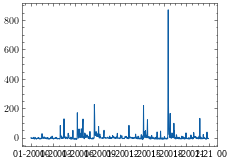

In [7]:
plt.plot(new_df[new_df.index.day==20][TARGETS_clean[1]])

In [8]:
smoothing_window_size = 16

In [9]:
new_df =exponential_window_smoothing(new_df,smoothing_window_size)

In [10]:
new_df_2 = resample_regular(new_df, "2min")

In [11]:
TARGETS_clean

['2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Carbon dioxide CO2',
 'Ammonia NH3']

In [12]:
from brokenaxes import brokenaxes
from datetime import datetime

In [13]:
pd.to_datetime(df.index[0])

Timestamp('2020-01-15 11:42:01', freq='2T')

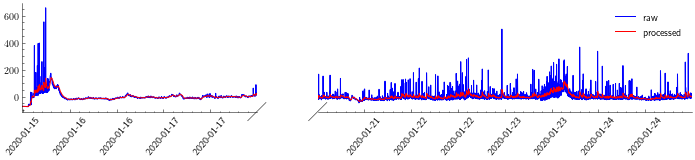

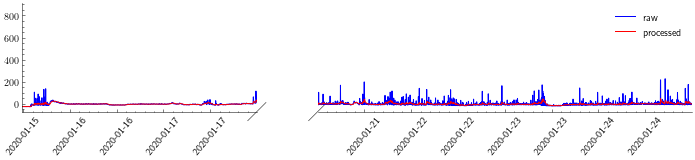

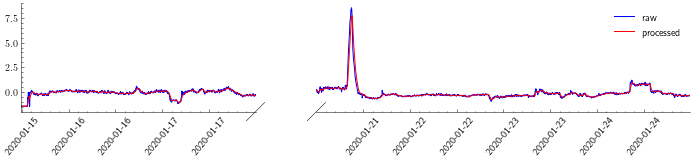

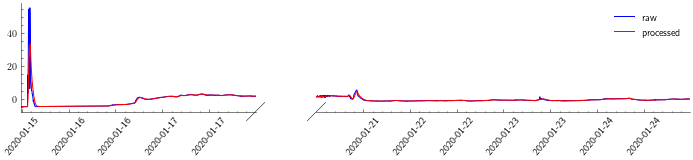

In [16]:
for i in range(4):
    fig = plt.figure(figsize=(12,2))
    bax = brokenaxes(xlims=((df.index[0].to_pydatetime(),  df[df.index.day==17].index[-1].to_pydatetime()), 
                            (df[df.index.day==21].index[0].to_pydatetime(), df[df.index.day==24].index[-1].to_pydatetime()),
                                                   ))
    bax.tick_params(axis="x", rotation=50)

    bax.plot(df[TARGETS_clean[i]], c='b', label='raw')
    bax.plot(new_df[TARGETS_clean[i]], c='r', label='processed')
    bax.legend()
    fig.savefig(f'processing_influence_{TARGETS_clean[i]}_{smoothing_window_size}.pdf', bbox_inches='tight')

In [1931]:
datetime(2008,1,1)

datetime.datetime(2008, 1, 1, 0, 0)

In [1932]:
df.index[0].to_pydatetime()

datetime.datetime(2020, 1, 15, 11, 42, 1)

In [2023]:
#new_df_2.to_pickle('20210508_df_for_causalimpact.pkl')

In [18]:
X, y = new_df[MEAS_COLUMNS], new_df[TARGETS_clean].values

In [21]:
target_0_config = { # https://wandb.ai/kjappelbaum/process_ml/runs/c0g28ueb/overview?workspace=user-kjappelbaum
    'n_estimators': 813,
    'max_depth': 71,
    'num_leaves': 5,
    'reg_alpha': 0.06481,
    'reg_lambda': 0.1105,
    'subsample': 0.6701,
    'colsample_bytree': 0.7241,
    'min_child_weight': 0.001554,
}

target_1_config = { 
    'n_estimators': 87,
    'max_depth': 18,
    'num_leaves': 26,
    'reg_alpha': 0.1539,
    'reg_lambda': 1.263,
    'subsample': 0.7269,
    'colsample_bytree': 0.4153,
    'min_child_weight': 0.08785,
   # 'objective': 'huber'
}


target_2_config = { # https://wandb.ai/kjappelbaum/process_ml/runs/571rdxdm/overview?workspace=user-kjappelbaum
    'n_estimators': 79,
    'max_depth': 89,
    'num_leaves': 146,
    'reg_alpha': 0.1246,
    'reg_lambda': 2.078,
    'subsample': 0.9498,
    'colsample_bytree': 0.4126,
    'min_child_weight': 0.09028,
    #'objective': 'huber'
}



In [22]:
from sklearn.ensemble import BaggingRegressor

In [99]:
xgb_co2 = BaggingRegressor(LGBMRegressor(**target_0_config), n_estimators=10)
xgb_2amp = BaggingRegressor(LGBMRegressor(**target_1_config), n_estimators=10)
xgb_piperazine = BaggingRegressor(LGBMRegressor(**target_2_config), n_estimators=10)

In [100]:
xgb_nh3 = BaggingRegressor(LGBMRegressor(**target_0_config), n_estimators=10)

In [101]:
# X_train, X_test, y_train, y_test = train_test_split(X_, y, train_size=0.8) # random split
X_train, X_test, y_train, y_test = X_[:4000], X[4000:], y[:4000], y[4000:]

In [102]:
scaler = StandardScaler()

In [103]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
xgb_co2.fit(X_train, y_train[:, 2])
xgb_2amp.fit(X_train, y_train[:, 0])
xgb_piperazine.fit(X_train, y_train[:, 1])

BaggingRegressor(base_estimator=LGBMRegressor(colsample_bytree=0.4126,
                                              max_depth=89,
                                              min_child_weight=0.09028,
                                              n_estimators=79, num_leaves=146,
                                              reg_alpha=0.1246,
                                              reg_lambda=2.078,
                                              subsample=0.9498))

In [105]:
xgb_nh3.fit(X_train, y_train[:, 3])

BaggingRegressor(base_estimator=LGBMRegressor(colsample_bytree=0.7241,
                                              max_depth=71,
                                              min_child_weight=0.001554,
                                              n_estimators=813, num_leaves=5,
                                              reg_alpha=0.06481,
                                              reg_lambda=0.1105,
                                              subsample=0.6701))

In [106]:
def make_parity_plot(model, X_test, X_train, y_test_, y_train_, outname=None):
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True)

    ax[0].set_ylabel(r'$\hat{y}$')
    ax[0].set_title('test')
    ax[1].set_title('train')

    ax[0].scatter(y_test_, predictions_test, s=.2, alpha=.7)
    ax[1].scatter(y_train_, predictions_train, s=.2, alpha=.7)

    for a in ax: 
        a.spines['top'].set_color('none')
        a.spines['right'].set_color('none')
        a.spines['left'].set_smart_bounds(True)
        a.spines['bottom'].set_smart_bounds(True)
        a.set_xlabel(r'$y_\mathrm{true}$')

        x_lims = a.get_xlim()
        y_lims = a.get_ylim()
        a.plot(x_lims, y_lims, '--k')


    fig.tight_layout()

    if outname is not None: 
        fig.savefig(outname, bbox_inches='tight')

<ipython-input-106-2ffccf1f1bb1>:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['left'].set_smart_bounds(True)
<ipython-input-106-2ffccf1f1bb1>:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['bottom'].set_smart_bounds(True)


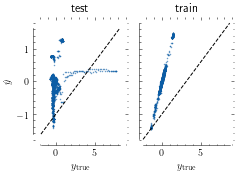

In [107]:
make_parity_plot(xgb_co2, X_test, X_train, y_test[:,2], y_train[:,2], 'co2_final_model_time_split.pdf')

<ipython-input-106-2ffccf1f1bb1>:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['left'].set_smart_bounds(True)
<ipython-input-106-2ffccf1f1bb1>:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['bottom'].set_smart_bounds(True)


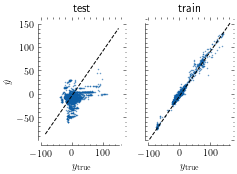

In [108]:
make_parity_plot(xgb_2amp, X_test, X_train, y_test[:,0], y_train[:,0], '2amp_final_model_time_split.pdf')

<ipython-input-106-2ffccf1f1bb1>:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['left'].set_smart_bounds(True)
<ipython-input-106-2ffccf1f1bb1>:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['bottom'].set_smart_bounds(True)


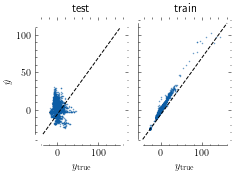

In [109]:
make_parity_plot(xgb_piperazine, X_test, X_train, y_test[:,1], y_train[:,1], 'piperazine_final_model_time_split.pdf')

<ipython-input-106-2ffccf1f1bb1>:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['left'].set_smart_bounds(True)
<ipython-input-106-2ffccf1f1bb1>:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['bottom'].set_smart_bounds(True)


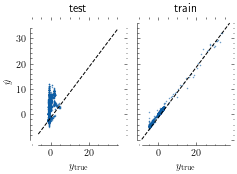

In [110]:
make_parity_plot(xgb_nh3, X_test, X_train, y_test[:,3], y_train[:,3], 'ammonia_final_model_time_split.pdf')

In [61]:
joblib.dump(xgb_co2, 'final_model/xgb_co2.joblib')
joblib.dump(xgb_2amp, 'final_model/xgb_2amp.joblib')
joblib.dump(xgb_piperazine, 'final_model/xgb_piperazine.joblib')

['final_model/xgb_piperazine.joblib']

In [62]:
joblib.dump(xgb_nh3, 'final_model/xgb_ammonia.joblib')

['final_model/xgb_ammonia.joblib']

## Feature importance

In [64]:
import shap

In [65]:
shap_values_co2 = []
shap_values_2amp = []
shap_values_piperazine = []


def get_shap_values(bagging_estimator):
    values = []
    for estimator in bagging_estimator.estimators_[:10]:
        shap_ = shap.TreeExplainer(estimator)
        values.append(shap_.shap_values(X_))
    
    return np.array(values)


shap_values_co2 = get_shap_values(xgb_co2)
shap_values_2amp = get_shap_values(xgb_2amp)
shap_values_piperazine = get_shap_values(xgb_piperazine)

In [66]:
shap_values_ammonia = get_shap_values(xgb_nh3)

In [67]:
shap_values_co2_mean = shap_values_co2.mean(axis=0)
shap_values_2amp_mean = shap_values_2amp.mean(axis=0)
shap_values_piperazine_mean = shap_values_piperazine.mean(axis=0)
shap_values_ammonia_mean = shap_values_ammonia.mean(axis=0)

shap_values_co2_std = shap_values_co2.std(axis=0)
shap_values_2amp_std = shap_values_2amp.std(axis=0)
shap_values_piperazine_std = shap_values_piperazine.std(axis=0)
shap_values_ammonia_std = shap_values_ammonia.std(axis=0)

In [68]:
CLEAN_FEATURE_NAMES =  [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#     "FI-23",
#     "FI-20",
#     "FI-20/FI-23",
#    "TI-22",
    "deltat",
    "TI-35",
    "deltat2"
]

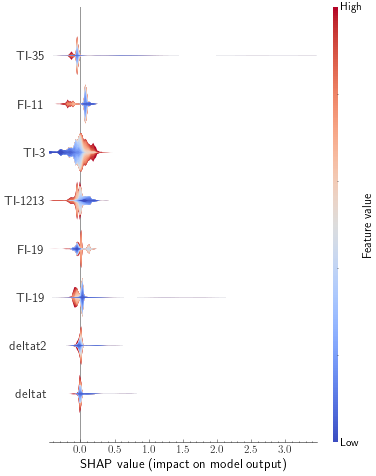

In [69]:
shap.summary_plot(shap_values_co2_mean, 
                  X_, 
                  feature_names=CLEAN_FEATURE_NAMES,
                  plot_type='layered_violin',
                  show=False, 
                  max_display=10,
                  plot_size=(6,8),
                  alpha=.1,
                  cmap='coolwarm',
                 )

plt.savefig('final_model/shap_co2.pdf', bbox_inches='tight')

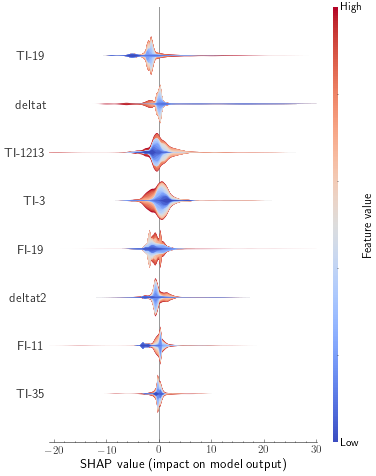

In [70]:
shap.summary_plot(shap_values_2amp_mean, 
                  X_, 
                  feature_names=CLEAN_FEATURE_NAMES,
                  plot_type='layered_violin',
                  max_display=10,
                  plot_size=(6,8),
                  alpha=.1,
                  cmap='coolwarm',
                  show=False
                 )
plt.savefig('final_model/shap_2amp.pdf', bbox_inches='tight')

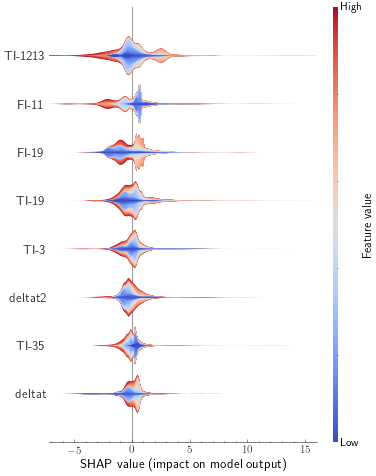

In [71]:
shap.summary_plot(shap_values_piperazine_mean, 
                  X_, 
                  feature_names=CLEAN_FEATURE_NAMES,
                  plot_type='layered_violin',
                  show=False, 
                  max_display=10,
                  plot_size=(6,8),
                  alpha=.1,
                  cmap='coolwarm',
                 )
plt.savefig('final_model/shap_piperazine.pdf', bbox_inches='tight')

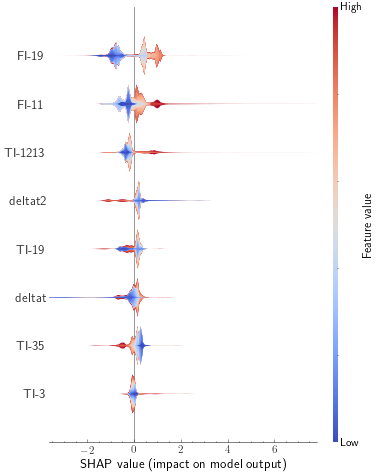

In [72]:
shap.summary_plot(shap_values_ammonia_mean, 
                  X_, 
                  feature_names=CLEAN_FEATURE_NAMES,
                  plot_type='layered_violin',
                  show=False, 
                  max_display=10,
                  plot_size=(6,8),
                  alpha=.1,
                  cmap='coolwarm',
                 )

plt.savefig('final_model/shap_ammonia.pdf', bbox_inches='tight')

## Scenarios w relative variation 

In [1342]:
from collections import defaultdict
from copy import deepcopy

In [1343]:
def run_targets(model, feature_levels):
    df_ = deepcopy(df)
    for k, v in feature_levels.items():
        if k == "valve-position-12":
            df_[k] = v
        else:
            df_[k] = df_[k] + v / 100 * np.abs(df_[k])

    predictions = model.predict(df_)
    return predictions

In [1392]:
def run_grid(
    model,
    feature_a: str = "TI-19",
    feature_b: str = "FI-19",
    lower: float = -20,
    upper: float = 20,
    num_points: int = 21,
):
    grid = np.linspace(lower, upper, num_points)
    results_double_new = defaultdict(dict)

    if feature_a == "valve-position-12":
        grid_a = [0, 1]
    else:
        grid_a = grid
    if feature_b == "valve-position-12":
        grid_b = [0, 1]
    else:
        grid_b = grid

    for point_a in grid_a:
        for point_b in grid_b:
            results_double_new[point_a][point_b] = run_targets(model,
                {feature_a: point_a, feature_b: point_b}
            )
    return results_double_new


In [1370]:
def get_grids(d): 
    outer_keys = sorted(d.keys())
    inner_keys = sorted(d[outer_keys[0]].keys())
    
    return outer_keys, inner_keys

In [1371]:
def plot_effect(d):
    outer, inner =  get_grids(d)
    image = np.zeros((len(outer), len(inner)))
    
    for i, outer_key in enumerate(outer):
        for j, inner_key in enumerate(inner):
            image[i][j] =  np.mean(d[outer_key][inner_key] - d[0][0])
    
    return image

In [1397]:
d1 = run_grid(xgb_2amp, "deltat", "FI-20/FI-23")

In [1398]:
d0 = run_grid(xgb_piperazine, "deltat", "FI-20/FI-23")

In [1402]:
i1 = plot_effect(d1)

[-20.0, -18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0] [-20.0, -18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


In [1405]:
from scipy.ndimage.filters import gaussian_filter

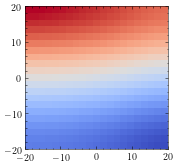

In [1411]:
plt.imshow(gaussian_filter(i1, 3), cmap='coolwarm', extent=[-20, 20, -20, 20])

[-20.0, -18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0] [-20.0, -18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


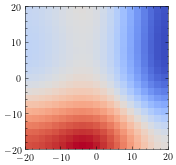

In [1412]:
i0 = plot_effect(d0)
plt.imshow(gaussian_filter(i0, 3), cmap='coolwarm', extent=[-20, 20, -20, 20])

## Compile DF

In [11]:
import datetime as dt

In [12]:
good_days = [15,16, 17,20,  21,22,23,24]

In [13]:
good_rows = []
for i in range(len(new_df)):
    if new_df.index[i].day in good_days:
        good_rows.append(new_df.iloc[i])

In [14]:
df_downsampled = pd.DataFrame(good_rows)

In [15]:
df_downsampled.index = dt.datetime(2010,1,1) + pd.TimedeltaIndex(np.arange(len(df_downsampled))*2, unit='min')

In [16]:
df_downsampled.to_pickle('20210624_df_cleaned.pkl')

In [17]:
len(df_downsampled)

5409

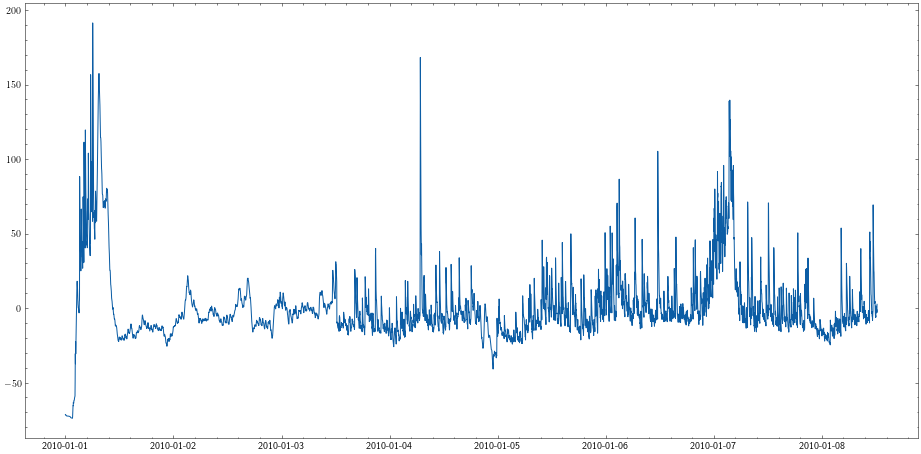

In [18]:
plt.figure(figsize=(16,8))
plt.plot(df_downsampled[TARGETS_clean[0]])